#**Milestone 2**

In [1]:
# It is recommended to upgrade the statsmodels library. 
# Uncomment the below code to upgrade statsmodels
#!pip install statsmodels --upgrade

### **Natural gas based CO2 emission forecasting**

For developing the time series model and forecasting, you are expected to use the natural gas CO2 emission from the electrical power generation. We need to slice this data:

In [2]:
import pandas as pd
df = pd.read_csv('CO2_data_cleaned')
df.columns

Index(['YYYYMM', 'MSN', 'Value', 'Description'], dtype='object')

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
#we have null date sections
df.isnull().sum()

YYYYMM         355
MSN              0
Value            0
Description      0
dtype: int64

In [5]:
df= df.dropna()

In [6]:
df_natural_gas = df[df.Description =='Natural Gas Electric']

/var/folders/39/889_w1pj4hb2t9y3wsbyrpkhd5115b/T/ipykernel_44053/2295995369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_natural_gas['emission_date']= pd.to_datetime(df_natural_gas['YYYYMM'])
/var/folders/39/889_w1pj4hb2t9y3wsbyrpkhd5115b/T/ipykernel_44053/2295995369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_natural_gas['month'] = df_natural_gas['emission_date'].dt.month


<AxesSubplot:xlabel='month'>

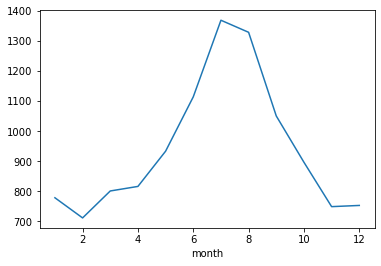

In [7]:
###Slice the data to get the monthly total CO2 emissions of Natural Gas Electric Power Sector
import datetime as dt
df_natural_gas['emission_date']= pd.to_datetime(df_natural_gas['YYYYMM'])
df_natural_gas['month'] = df_natural_gas['emission_date'].dt.month

# Get the start and end months
df_natural_gas.groupby('month')['Value'].sum().plot()

**observations**
* emisssions seem highest in summer months and lowest in winter; perhaps gas energy is mostly used to cool houses, rather than heat it? 
* Lowest in spring and fall.

In [8]:
 #Check 1st few rows of data
df_natural_gas.head()

,YYYYMM,MSN,Value,Description,emission_date,month
1970-01-01 00:00:00.000000566,1973-01-01,NNEIEUS,12.175,Natural Gas Electric,1973-01-01,1
1970-01-01 00:00:00.000000567,1973-02-01,NNEIEUS,11.708,Natural Gas Electric,1973-02-01,2
1970-01-01 00:00:00.000000568,1973-03-01,NNEIEUS,13.994,Natural Gas Electric,1973-03-01,3
1970-01-01 00:00:00.000000569,1973-04-01,NNEIEUS,14.627,Natural Gas Electric,1973-04-01,4
1970-01-01 00:00:00.000000570,1973-05-01,NNEIEUS,17.344,Natural Gas Electric,1973-05-01,5


In [9]:
#lets only grab date and value for graphing going forwards

###**Split the dataset**

In [10]:
# Split the data into train and test

#training is the historic data up to 2012
train_df = df_natural_gas[['Value', 'YYYYMM']].set_index('YYYYMM').loc[:'2012-01-01']
train_df.index = pd.to_datetime(train_df.index)

#testing is the last 10 years of data
test_df = df_natural_gas[['Value', 'YYYYMM']].set_index('YYYYMM').loc['2012-01-01':]
test_df.index = pd.to_datetime(test_df.index)

In [11]:
test_df

,Value
YYYYMM,
2012-01-01,35.110
2012-02-01,34.877
2012-03-01,36.456
2012-04-01,38.626
2012-05-01,43.922
2012-06-01,47.572
2012-07-01,58.490
2012-08-01,54.282
2012-09-01,43.384


###**Test the Stationarity**

In [12]:
#Import the required package

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

###**Test the stationarity through Visualization**

#### **Observations and Insights: **

* Rolling mean seems relatively stable, not taking into account seasonal variability 

### **Test the stationarity using the Augmented Dickey-Fuller Test**

Use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not. The null and alternate hypotheses for the ADF Test are defined as:

**- Null hypothesis:** The Time Series is non-stationary


**- Alternative hypothesis:** The Time Series is stationary

In [13]:
#Define a function to use adfuller test
def adfuller(dataset):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(dataset['Value'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(train_df)

Dickey-Fuller Test: 
Test Statistic            1.693504
p-value                   0.998113
Lags Used                15.000000
No. of Observations     453.000000
Critical Value (1%)      -3.444868
Critical Value (5%)      -2.867941
Critical Value (10%)     -2.570180
dtype: float64


- **Observations and Insights**

* p value is 0.998133; therefore we fail to reject the null hypothesis that the data is non-stationary. 
* We therefore conclude that the data is non-stationary. 

###**Transformation of the dataset into a stationary one**

**We can use some of the following methods to convert a non-stationary series into a stationary one:**


1. Log Transformation
2. Differencing the series (lagged series)

We take the average of ‘k’ consecutive values depending on the frequency of time series (in this capstone 12 months). 

Here, we will take the average over the past 1 year.

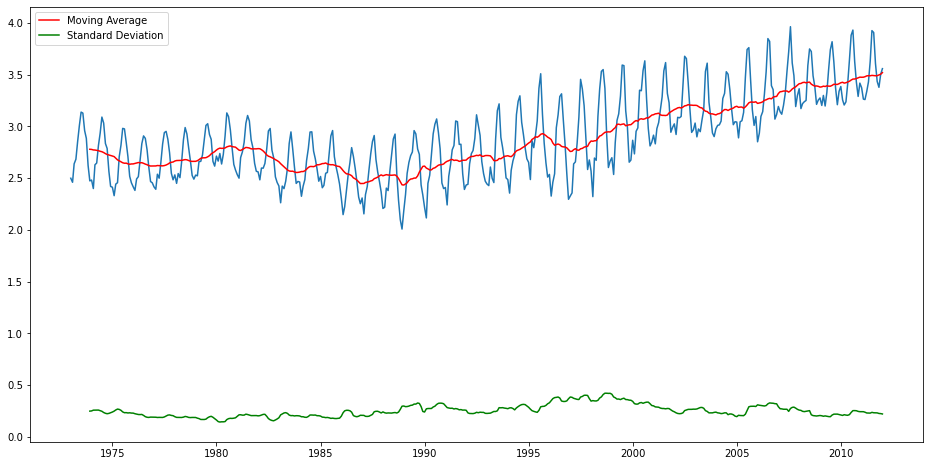

In [14]:
 # Visualize the rolling mean and standard deviation after using log transformation
import numpy as np
import matplotlib.pylab as plt
import matplotlib


plt.figure(figsize=(16,8))
df_log = np.log(train_df)
df_log.index = pd.to_datetime(df_log.index)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()

plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations and Insights: **

* Moving average of log of values stays relatively consistent although increasses from 2.75 to 3.5 in recent history
* Standard Deviation is consistent around .35

**Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same.**

####**Think about it:**

- Do you need to remove the null values that we get after applying differencing method?

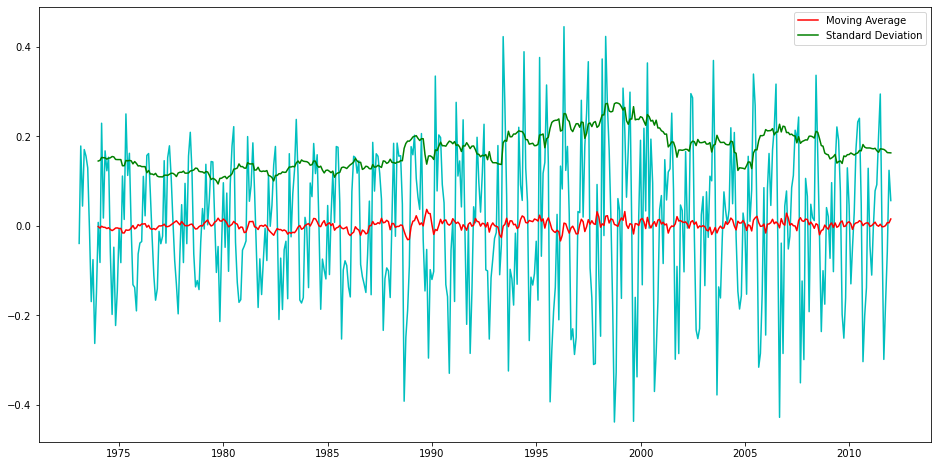

In [15]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations and Insights: **
* With the df_shift, we can observe that stationarity has been achieved; our moving average stays close to zero, even when the data (blue) wildly oscillates.

In [16]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -4.531148
p-value                   0.000173
Lags Used                18.000000
No. of Observations     449.000000
Critical Value (1%)      -3.444998
Critical Value (5%)      -2.867999
Critical Value (10%)     -2.570210
dtype: float64


**Observations and Insights: **
* p value of well below 0.05! We can be confident that the shift of the data makes it stationary. 

### **Elimination of trend and seasonality: Decomposition**

In [17]:
train_df.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01', '2012-01-01'],
              dtype='datetime64[ns]', name='YYYYMM', length=469, freq=None)

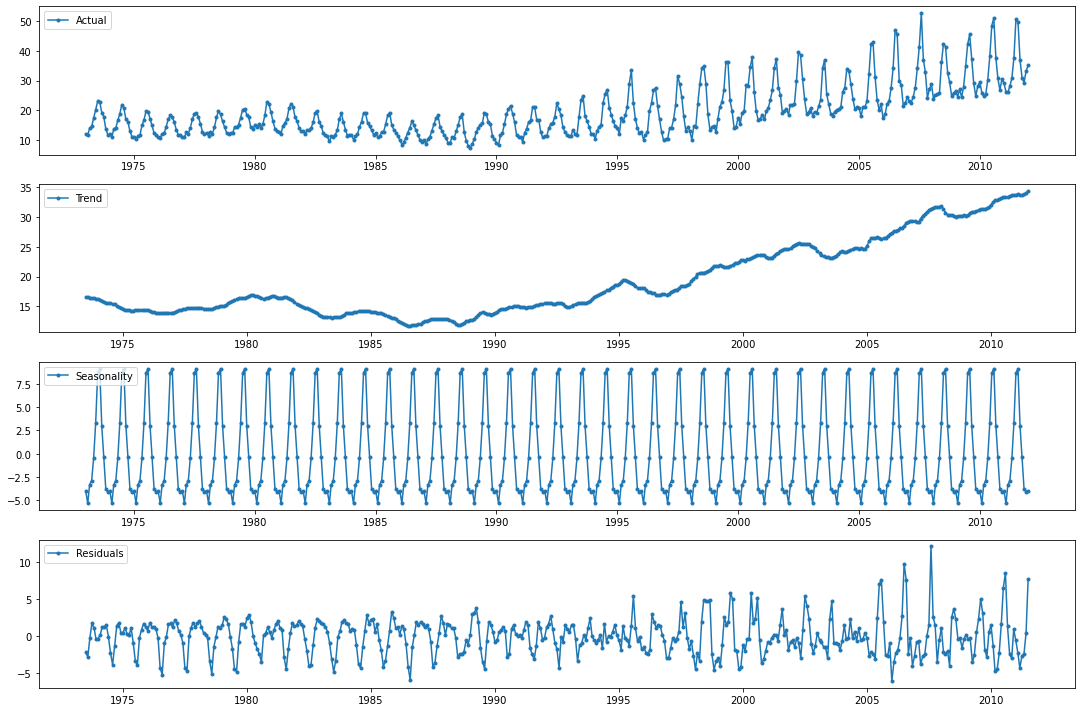

In [18]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(train_df)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(train_df, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

# You can follow the previous case study/projects notebook to plot it

**Observations and Insights: **
* We can see that there are significant trend, seasonality and residuals components in the series
* The plot for seasonality shows emissions spike in winters

**Plot the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models**

### **Find optimal parameters (P, Q) and build the AR, MA, ARMA & ARIMA models**

<Figure size 1152x576 with 0 Axes>

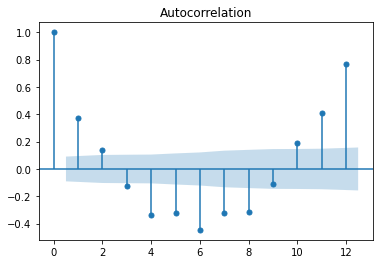

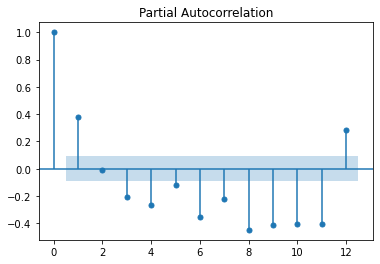

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**OBSERVATIONS**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

**Plot the ACF and PACF charts and find the optimal parameters**

###**AR Model**

Order p is the lag value after which the PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series.

Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations.

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


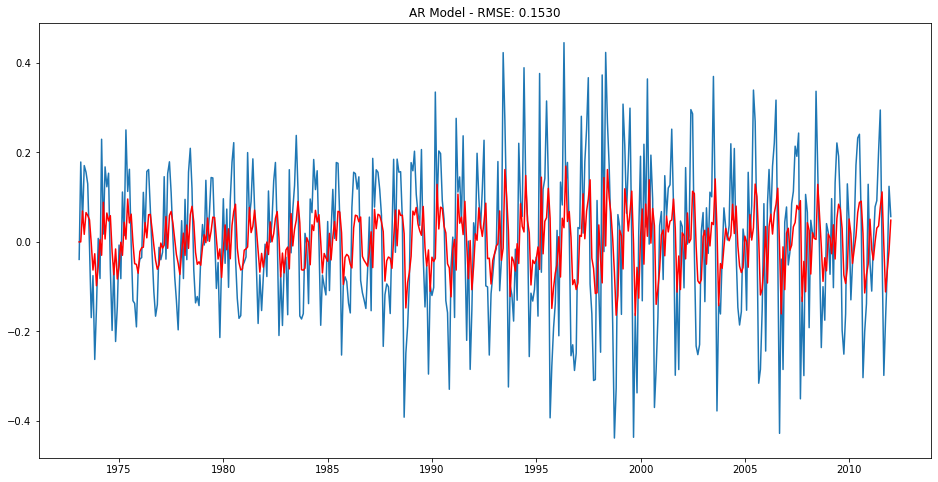

In [20]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=2) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0, end= len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['Value'], squared=False))  #Calculating rmse
plt.show()

**Observations & Insights: **
* Low RMSE of 0.15 indicates its a pretty good model, but we can maybe do better with tuning.

###**MA Model**

####**Think about it:**

- Do we really have to find AR & I value other than 0 to forecast on the MA based model?

Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time.

Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations.

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


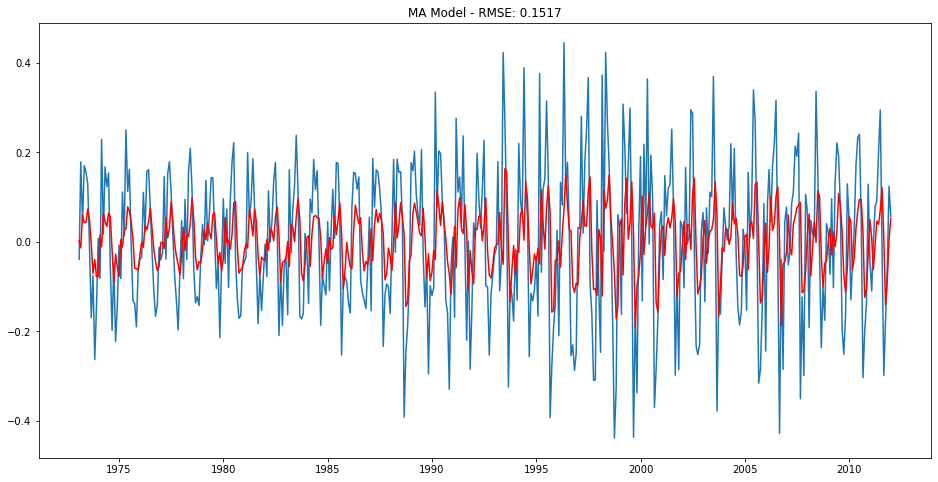

In [21]:
from statsmodels.tsa.arima.model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order = (0, 0, 2)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['Value'], squared=False))
plt.show()

**Observations & Insights: **
* RMSE is actually a bit higher with the MA model; 0.1550 instead of 0.1531. It is rather negligible, so either approach seems good.

###**ARMA MODEL**

**We will be using the above AR lag(P) & MA lag(Q) as a paramter** and d=0 in ARIMA so that it will work as an ARMA model.

Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations.

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ebates/opt/anaconda3/lib/py

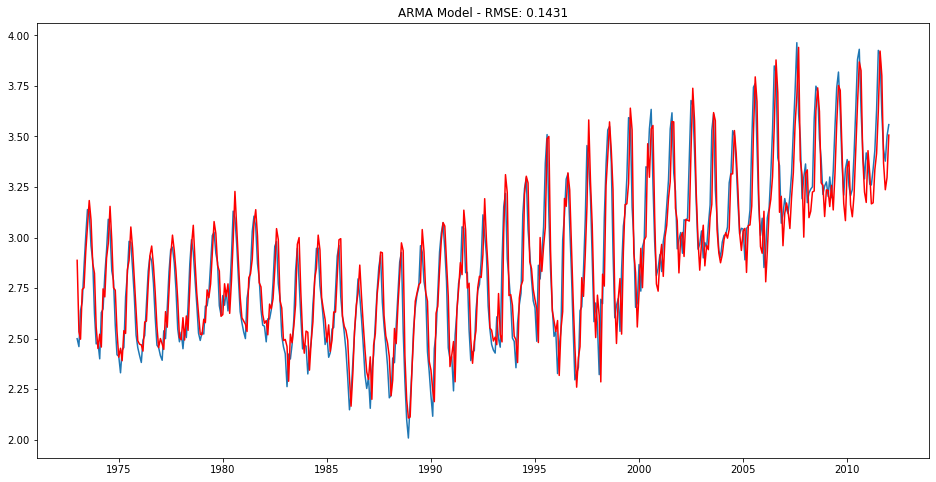

In [22]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_log, order=(3,0,3)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit() #fit the model
plt.plot(df_log)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_log['Value'], squared=False))
plt.show()

**Observations & Insights: **
* With an RMSE value of 0.1508, we have a clear lowest RMSE score

**Check the AIC value of the model**

In [23]:
results_ARMA.aic

-480.57745165725726

###**ARIMA MODEL**

**Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations.**

In [24]:
from statsmodels.tsa.arima_model import ARIMA

In [25]:
!pip install statsmodels==0.12.1

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.60619D-01    |proj g|=  8.00839D-03

At iterate    5    f= -7.60677D-01    |proj g|=  9.27813D-03

At iterate   10    f= -7.60754D-01    |proj g|=  1.81519D-03

At iterate   15    f= -7.60825D-01    |proj g|=  4.97434D-02

At iterate   20    f= -7.61053D-01    |proj g|=  2.42981D-03

At iterate   25    f= -7.61363D-01    |proj g|=  1.07589D-01

At iterate   30    f= -7.61770D-01    |proj g|=  8.31631D-03

At iterate   35    f= -7.61819D-01    |proj g|=  4.82964D-02

At iterate   40    f= -7.61937D-01    |proj g|=  9.32808D-03

At iterate   45    f= -7.61979D-01    |proj g|=  2.33386D-03

At iterate   50    f= -7.61993D-01    |proj g|=  1.05681D-02

At iterate   55    f= -7.62015D-01    |proj g|=  2.55481D-03

At iterate   60    f= -7.62029D-01    |proj g|=  6.21472D-03

At iterate   65    f= -7.6

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


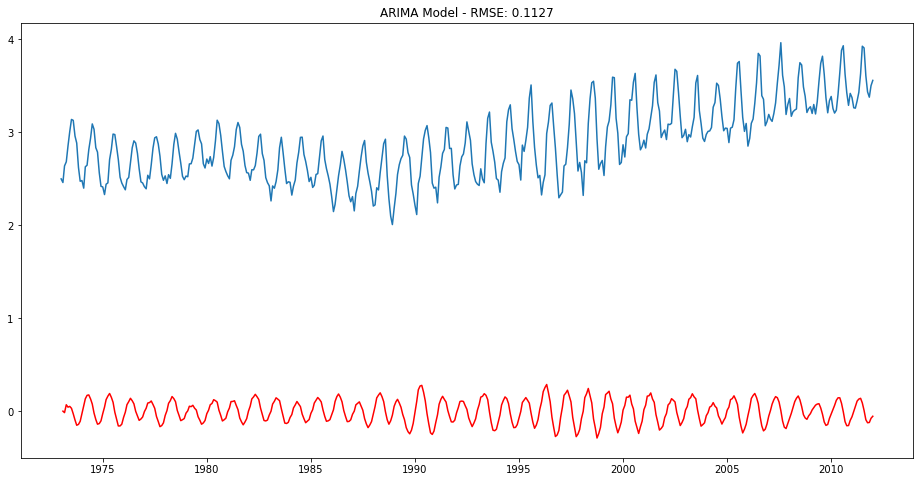

In [26]:
plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(3,1,3)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model
plt.plot(df_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['Value'], squared=False))
plt.show()

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.60619D-01    |proj g|=  8.00839D-03

At iterate    5    f= -7.60677D-01    |proj g|=  9.27813D-03

At iterate   10    f= -7.60754D-01    |proj g|=  1.81519D-03

At iterate   15    f= -7.60825D-01    |proj g|=  4.97434D-02

At iterate   20    f= -7.61053D-01    |proj g|=  2.42981D-03

At iterate   25    f= -7.61363D-01    |proj g|=  1.07589D-01

At iterate   30    f= -7.61770D-01    |proj g|=  8.31631D-03

At iterate   35    f= -7.61819D-01    |proj g|=  4.82964D-02

At iterate   40    f= -7.61937D-01    |proj g|=  9.32808D-03

At iterate   45    f= -7.61979D-01    |proj g|=  2.33386D-03

At iterate   50    f= -7.61993D-01    |proj g|=  1.05681D-02

At iterate   55    f= -7.62015D-01    |proj g|=  2.55481D-03

At iterate   60    f= -7.62029D-01    |proj g|=  6.21472D-03

At iterate   65    f= -7.6

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


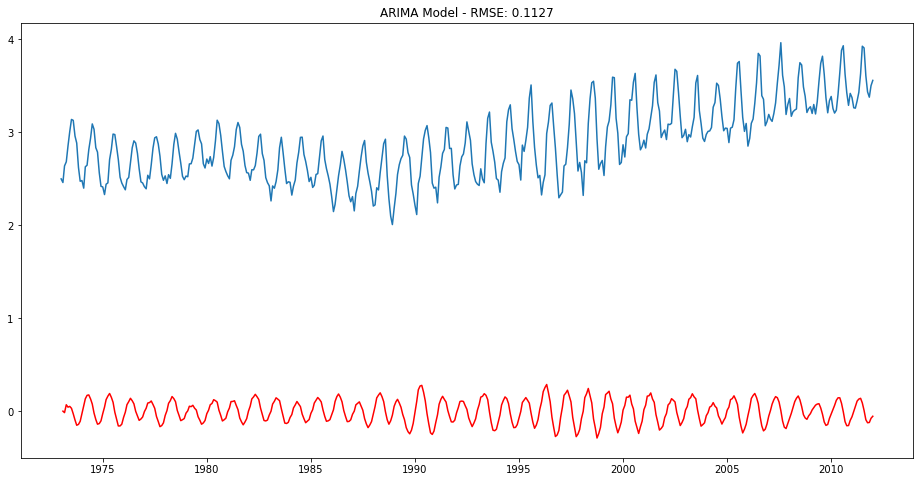

In [34]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(3,1,3)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model
plt.plot(df_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['Value'], squared=False))
plt.show()

**Check the AIC value of the model**

In [35]:
results_ARIMA.aic

-697.344016143164

###**Inverse Transformation**

**Use the correct inverse transformation depending on the model chosen to get back the original values.**



**Apply an inverse transformation on the predictions of the chosen model**

In [36]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

YYYYMM
1973-02-01    0.001791
1973-03-01   -0.014308
1973-04-01    0.070450
1973-05-01    0.044739
1973-06-01    0.052774
                ...   
2011-09-01   -0.090131
2011-10-01   -0.122876
2011-11-01   -0.120364
2011-12-01   -0.075046
2012-01-01   -0.053106
Length: 468, dtype: float64

**Plot the original vs predicted series**

In [37]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum() # use .cumsum fuction on the predictions
predictions_cumsum

YYYYMM
1973-02-01    0.001791
1973-03-01   -0.012517
1973-04-01    0.057933
1973-05-01    0.102673
1973-06-01    0.155446
                ...   
2011-09-01    1.092154
2011-10-01    0.969278
2011-11-01    0.848914
2011-12-01    0.773868
2012-01-01    0.720762
Length: 468, dtype: float64

In [38]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

YYYYMM
1973-01-01    2.499385
1973-02-01    2.501176
1973-03-01    2.486868
1973-04-01    2.557318
1973-05-01    2.602057
                ...   
2011-09-01    3.591538
2011-10-01    3.468663
2011-11-01    3.348298
2011-12-01    3.273252
2012-01-01    3.220146
Length: 469, dtype: float64

In [39]:
#Third step - applying exponential transformation
predictions_ARIMA = np.exp(predictions_log) #use exponential function
predictions_ARIMA

YYYYMM
1973-01-01    12.175000
1973-02-01    12.196827
1973-03-01    12.023561
1973-04-01    12.901172
1973-05-01    13.491467
                ...    
2011-09-01    36.289858
2011-10-01    32.093794
2011-11-01    28.454274
2011-12-01    26.397056
2012-01-01    25.031782
Length: 469, dtype: float64

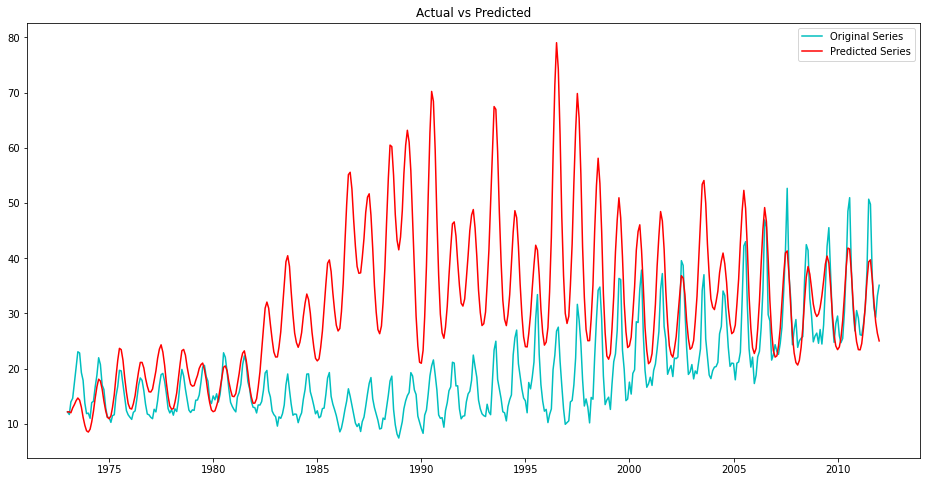

In [43]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_df, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations & Insights: **
* Model seems laregly accurate for early and late data forecast, but peaks quite a bit in the middle. (1985 to 2000)

###**Forecast the values for next 96 months and compare it with test data**

In [43]:
#Forecasting the values for next 24 months
forecasted_ARIMA = results_ARIMA.forecast(steps=96) #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA[0]

array([3.53532579, 3.52486838, 3.54569034, 3.57548322, 3.62223876,
       3.65771156, 3.68915143, 3.69350675, 3.68673363, 3.65632996,
       3.62701723, 3.59182715, 3.57571849, 3.56760794, 3.58451509,
       3.60660436, 3.64291895, 3.6692195 , 3.69397088, 3.69688511,
       3.69293363, 3.66978597, 3.64894922, 3.62227147, 3.6113866 ,
       3.60507756, 3.61897464, 3.63532615, 3.66374493, 3.68322001,
       3.70290729, 3.70480818, 3.70293437, 3.68529608, 3.67077135,
       3.65053202, 3.64350624, 3.63858934, 3.65016343, 3.66225148,
       3.68468975, 3.69909582, 3.71493956, 3.71614069, 3.71578665,
       3.70234045, 3.69250654, 3.67714602, 3.67296112, 3.66912834,
       3.67890188, 3.68783138, 3.70573121, 3.71638214, 3.72930015,
       3.7300306 , 3.73077866, 3.72053038, 3.71417342, 3.7025182 ,
       3.70041523, 3.69743414, 3.70580498, 3.71240335, 3.72685111,
       3.73472906, 3.74541214, 3.7458385 , 3.7473766 , 3.73957534,
       3.73578707, 3.72695355, 3.7263674 , 3.724062  , 3.73133

In [44]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0     3.535326
1     3.524868
2     3.545690
3     3.575483
4     3.622239
        ...   
91    3.781409
92    3.783889
93    3.779416
94    3.778901
95    3.773876
Length: 96, dtype: float64

In [45]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2012-01-1','2020-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

,forecasted
2012-01-01,3.535326
2012-02-01,3.524868
2012-03-01,3.545690
2012-04-01,3.575483
2012-05-01,3.622239
...,...
2019-08-01,3.781409
2019-09-01,3.783889
2019-10-01,3.779416
2019-11-01,3.778901


###**Check the RMSE on the original train and test data and write your conclusion from the above analysis.**

In [46]:
#Applying exponential transformation to the forecasted log values
forecasted_ARIMA = np.exp(df1['forecasted']) #use exponential function on forecasted data
forecasted_ARIMA

2012-01-01    34.306190
2012-02-01    33.949305
2012-03-01    34.663607
2012-04-01    35.711873
2012-05-01    37.421251
                ...    
2019-08-01    43.877802
2019-09-01    43.986771
2019-10-01    43.790481
2019-11-01    43.767896
2019-12-01    43.548544
Name: forecasted, Length: 96, dtype: float64

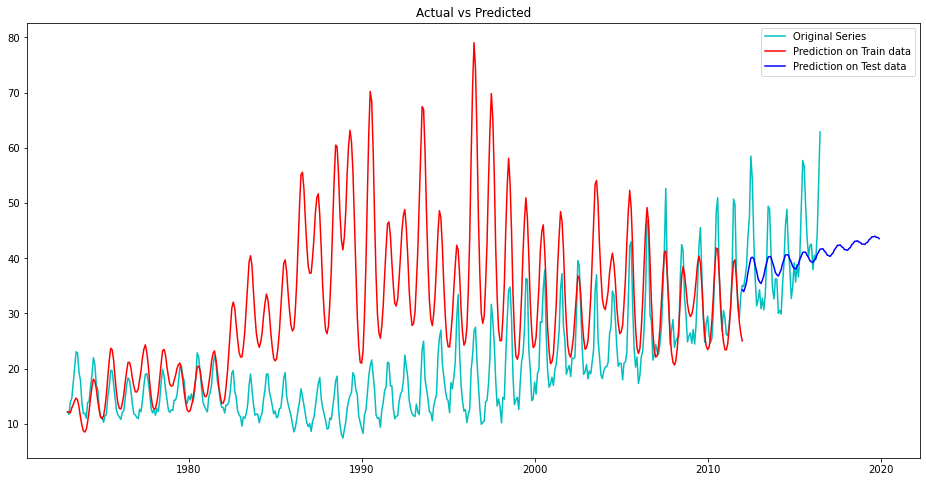

In [47]:
#Plotting the original vs predicted series
df_original = df_natural_gas[['Value', 'emission_date']]
df_original.index = pd.to_datetime(df_original.emission_date)
plt.figure(figsize=(16,8))
plt.plot(df_original['Value'], color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**ARMA MODEL

In [94]:
# Printing the fitted values
ARMA_predictions=pd.Series(results_ARMA.fittedvalues)
predictions

YYYYMM
1973-01-01    2.887891
1973-02-01    2.531625
1973-03-01    2.494465
1973-04-01    2.725122
1973-05-01    2.747225
                ...   
2011-09-01    3.800666
2011-10-01    3.385568
2011-11-01    3.293234
2011-12-01    3.335500
2012-01-01    3.480998
Length: 469, dtype: float64

In [95]:
#First step - doing cumulative sum
ARMA_predictions_cumsum = ARMA_predictions.cumsum() # use .cumsum fuction on the predictions
ARMA_predictions_cumsum

YYYYMM
1973-01-01       3.022037
1973-02-01       5.557328
1973-03-01       8.055995
1973-04-01      10.791075
1973-05-01      13.559624
                 ...     
2011-09-01    1338.122930
2011-10-01    1341.625347
2011-11-01    1344.936544
2011-12-01    1348.205231
2012-01-01    1351.607687
Length: 469, dtype: float64

In [96]:
#Second step - Adding the first value of the log series to the cumulative sum values
ARMA_predictions_log = pd.Series(df_log['Value'].iloc[0], index=df_log.index)
ARMA_predictions_log = ARMA_predictions_log.add(ARMA_predictions_cumsum, fill_value=0)
ARMA_predictions_log

YYYYMM
1973-01-01       5.521421
1973-02-01       8.056713
1973-03-01      10.555380
1973-04-01      13.290459
1973-05-01      16.059008
                 ...     
2011-09-01    1340.622315
2011-10-01    1344.124732
2011-11-01    1347.435929
2011-12-01    1350.704615
2012-01-01    1354.107072
Length: 469, dtype: float64

In [97]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2012-01-1','2020-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df2 = pd.DataFrame()
df2['forecasted'] = series1
df2.index = index
df2

,forecasted
2012-01-01,3.535326
2012-02-01,3.524868
2012-03-01,3.545690
2012-04-01,3.575483
2012-05-01,3.622239
...,...
2019-08-01,3.781409
2019-09-01,3.783889
2019-10-01,3.779416
2019-11-01,3.778901


In [98]:
#Applying exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(df2['forecasted']) #use exponential function on forecasted data
forecasted_ARMA

2012-01-01    34.306190
2012-02-01    33.949305
2012-03-01    34.663607
2012-04-01    35.711873
2012-05-01    37.421251
                ...    
2019-08-01    43.877802
2019-09-01    43.986771
2019-10-01    43.790481
2019-11-01    43.767896
2019-12-01    43.548544
Name: forecasted, Length: 96, dtype: float64

In [99]:
#Third step - applying exponential transformation
predictions_ARMA = np.exp(ARMA_predictions_log) #use exponential function
predictions_ARMA

/Users/ebates/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


YYYYMM
1973-01-01    2.499901e+02
1973-02-01    3.154903e+03
1973-03-01    3.838338e+04
1973-04-01    5.915250e+05
1973-05-01    9.426245e+06
                  ...     
2011-09-01             inf
2011-10-01             inf
2011-11-01             inf
2011-12-01             inf
2012-01-01             inf
Length: 469, dtype: float64

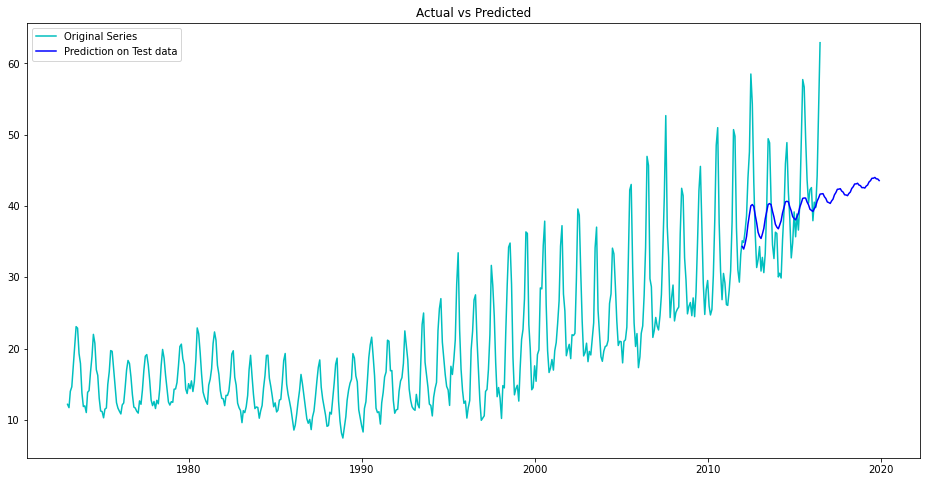

In [100]:
#Plotting the original vs predicted series
df_original = df_natural_gas[['Value', 'emission_date']]
df_original.index = pd.to_datetime(df_original.emission_date)
plt.figure(figsize=(16,8))
plt.plot(df_original['Value'], color = 'c', label = 'Original Series')
plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

####**Think about it:**
- Can we use other than RMSE measurement to check the performance of the model?

####**Think about it:**

 Can we use other forecasting methods such as SARIMA to improve our model performance?

- [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
- [Forecasting with Seasonal ARIMA in Python](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima)

## **Proposed Approach**
See powerpoint presentation for these answers. 

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?